In [2]:
# import essential libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import os
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [12]:
# specify the way to load the data

train_path = 'dataset/train'
test_path = 'dataset/test'
valid_path = 'dataset/valid'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=train_path, target_size=(224,224),  classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=valid_path, target_size=(224,224),  classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [4]:
# normal model architecture
'''
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))
'''

"\nmodel = Sequential()\nmodel.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)))\nmodel.add(MaxPool2D(pool_size=(2,2), strides=2))\nmodel.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))\nmodel.add(MaxPool2D(pool_size=(2,2), strides=2))\nmodel.add(Flatten())\nmodel.add(Dense(2,activation='softmax'))\n"

In [13]:
# we will use the Mobilenet model for our problem for better accuracy

# download the model
mobilenet = keras.applications.mobilenet.MobileNet()

In [14]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [15]:
# we will build a sequential model and then add all layers of vgg16_model in that model

model = Sequential()

for layer in mobilenet.layers[:-1]:
    model.add(layer)

In [8]:
# summary of our new model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0

In [16]:
# Now freeze all layers of this model except last 5

for layer in model.layers[:-6]:
    layer.trainable = False

In [17]:
# add new dense layer for the as output layer

model.add(Dense(units=2, activation='softmax'))

In [18]:
# specify the loss, optimizer and metrics parameters

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# now fit the model
model.fit(train_batches,validation_data=valid_batches, epochs=5, verbose=1)

Epoch 1/5
100/100 [==============================] - 61s 614ms/step - loss: 0.5121 - accuracy: 0.9380 - val_loss: 2.1901 - val_accuracy: 0.8550
Epoch 2/5
100/100 [==============================] - 61s 607ms/step - loss: 0.2999 - accuracy: 0.9730 - val_loss: 0.3908 - val_accuracy: 0.9650
Epoch 3/5
100/100 [==============================] - 62s 623ms/step - loss: 0.1504 - accuracy: 0.9860 - val_loss: 0.3618 - val_accuracy: 0.9550
Epoch 4/5
100/100 [==============================] - 59s 594ms/step - loss: 0.0516 - accuracy: 0.9940 - val_loss: 0.4965 - val_accuracy: 0.9650
Epoch 5/5
100/100 [==============================] - 63s 626ms/step - loss: 6.6908e-04 - accuracy: 1.0000 - val_loss: 0.3894 - val_accuracy: 0.9650


In [19]:
# model evaluation
loss, accuracy = model.evaluate(test_batches, verbose=1)
print("loss :-", loss)
print("accuracy :-", accuracy*100)

10/10 [==============================] - 4s 424ms/step - loss: 0.5309 - accuracy: 0.9700
loss :- 0.5308799147605896
accuracy :- 97.00000286102295


In [20]:
# let's predict the test data

test_labels = test_batches.classes
prediction = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [46]:
np.argmax(prediction, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int64)

In [42]:
# create the confusion matrix 
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(prediction, axis=-1))

In [43]:
# function to print the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[50  0]
 [ 3 47]]


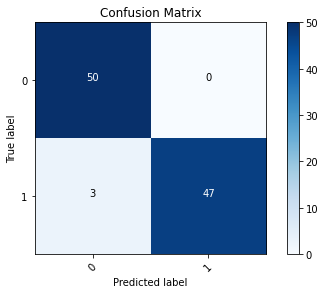

In [44]:
# plot the confusion matrix

cm_plot_labels = [0,1]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [32]:
from tensorflow.keras.models import load_model
from PIL import Image

new_model = load_model('dog_cat_classifier.h5')
    
def preprocess_img(image, target_size):
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image 
